In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rigidbody.plotter as plotter
import rigidbody.ode_solver as ode

In [2]:
plotter.set_context("paper")

In [3]:
def differential_drive_dynamic(x:np.ndarray, u:np.ndarray, r:float=1., a:float=0.5)-> np.ndarray:
    """
    Unicycle dynamics.
    The state x contains (x,y,phi).
    The input u contains (theta_r_dot, theta_l_dot)

    Parameters
    ----------
    u: np.ndarray (2,)
    x: np.ndarray (3,)
    r: radius of the wheel
    a: width of the car

    Returns
    -------
    dx_dt: np.ndarray (3,)
    """

    return np.array([[0.5*r*np.cos(x[-1]),0.5*r*np.cos(x[-1])],
                     [0.5*r*np.sin(x[-1]),0.5*r*np.sin(x[-1])],
                     [r/(2*a),-r/(2*a)]])@u

In [20]:
trajectory_init = np.array([0.,0.,0.])
N_t = 3000
dt = 1e-3
t_span = np.arange(N_t)*dt
trajectory = np.zeros((t_span.shape[0],3))
trajectory[0] = trajectory_init
max_speed = 5
turn_scale = 0.2
zeros_portion = np.pi*np.zeros((N_t//12,))
ones_portion = np.pi*np.ones((N_t//12,))
theta_r_dot = np.concatenate([ones_portion,ones_portion,zeros_portion,zeros_portion,ones_portion,ones_portion,turn_scale*ones_portion,turn_scale*ones_portion,ones_portion,ones_portion,zeros_portion,zeros_portion])
theta_l_dot = np.concatenate([ones_portion,ones_portion,turn_scale*ones_portion,turn_scale*ones_portion,ones_portion,ones_portion,zeros_portion,zeros_portion,ones_portion,ones_portion,zeros_portion,zeros_portion])
# phi_dot = np.random.randn(t_span.shape[0])*np.pi
u_t = max_speed*np.block([[theta_r_dot],
                [theta_l_dot]])
u_t = u_t.T

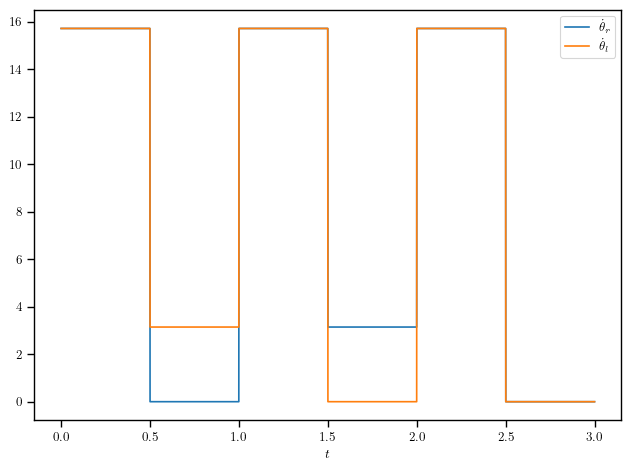

In [21]:
plt.plot(t_span,u_t, label=[r"$\dot\theta_r$",r"$\dot\theta_l$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()

In [22]:
for i in range(t_span.shape[0]-1):
    trajectory[i+1] = ode.rk_one_step(differential_drive_dynamic,trajectory[i],dt,u_t[i])

Text(0, 0.5, '$y$')

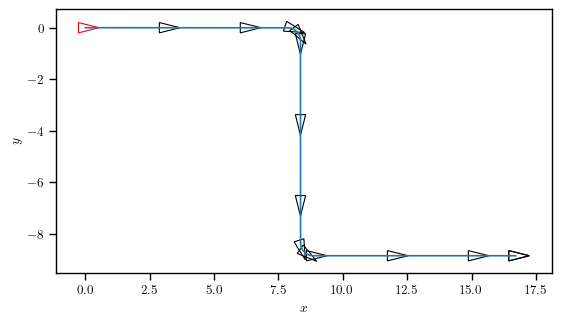

In [23]:
ax = plotter.two_d_trajectory_attitude_plot(trajectory,0.20,200,initial_color="red")
ax.set_aspect("equal")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
# plt.savefig('trajectory_unicycle.svg')

Text(0.5, 0, '$t$')

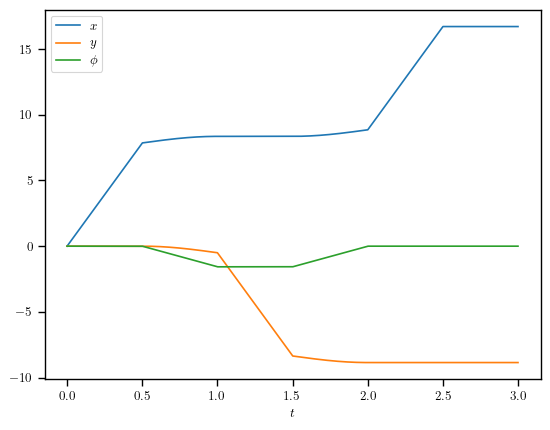

In [24]:
plt.plot(t_span,trajectory, label=[r"$x$",r"$y$",r"$\phi$"])
plt.legend()
plt.xlabel(r'$t$')

In [25]:
desired_trajectory = trajectory[:,:2]

Create a controller that would allow the vehicle follows the desired trajectory.
Using a combination of two PI controllers, responsible for maintaining the speed and the angular velocity, we can write
$e = x_d(t)-x(t)$
$\dot{\theta_r}+\dot{\theta_l} = K_{p,v} \|e(t)\|+ \int_0^t K_{i,v} \|e(s)\| ds$
$\phi_d = \text{atan2}(ey,ex)$
$\dot{\theta_r}-\dot{\theta_l} = K_{p,\phi} (\phi_d(t)-\phi(t)) + \int_0^t K_{i,\phi} (\phi_d(s)-\phi(s)) ds$

In [39]:
controlled_trajectory = np.zeros_like(trajectory)
controlled_trajectory[0] = np.array([0.,0.,np.pi/3])

Propagate the dynamics with control

In [40]:
K_p_v = 2e1
K_i_v = 1e0
K_p_phi = 4e1
K_i_phi = 2e-1

max_speed_control = 3*max_speed
sum_norm_e = 0
sum_e_phi = 0
u_hist = []
for i in range(t_span.shape[0]-1):
    e = desired_trajectory[i,:2] - controlled_trajectory[i,:2]
    norm_e = np.linalg.norm(e)
    theta_plus_dot = K_p_v*norm_e + K_i_v*sum_norm_e
    theta_plus_dot = np.minimum(theta_plus_dot,max_speed_control)
    sum_norm_e += norm_e
    phi_d = np.arctan2(e[1],e[0])

    #since phi_d can only be [0,2pi] this need to be handled properly
    if phi_d-controlled_trajectory[i,-1] < -np.pi:
        phi_d=phi_d+2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    elif phi_d-controlled_trajectory[i,-1] > np.pi:
        phi_d=phi_d-2*np.pi#*(controlled_trajectory[i,-1]//2*np.pi)
    else:
        phi_d = phi_d

    e_phi = (phi_d-controlled_trajectory[i,-1])
    sum_e_phi += e_phi
    theta_min_dot = K_p_phi*e_phi + K_i_phi*sum_e_phi
    theta_r_dot_ = 0.5*(theta_plus_dot+theta_min_dot)
    theta_l_dot_ = 0.5*(theta_plus_dot-theta_min_dot)
    u_ = np.array([theta_r_dot_,theta_l_dot_])
    u_hist.append(u_)
    controlled_trajectory[i+1] = ode.rk_one_step(differential_drive_dynamic,controlled_trajectory[i],dt,u_)
    # controlled_trajectory[i+1] = controlled_trajectory[i] + dt* kinematic_dynamic(controlled_trajectory[i],nu)
u_hist = np.stack(u_hist)

Text(0, 0.5, '$y$')

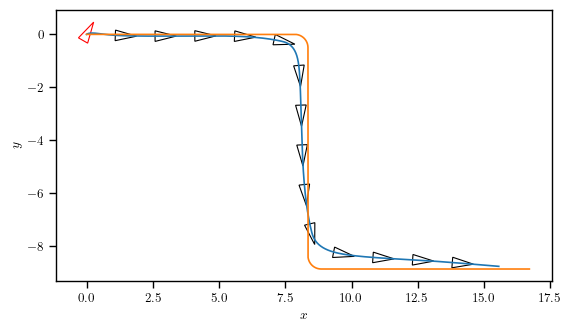

In [41]:
ax = plotter.two_d_trajectory_attitude_plot(controlled_trajectory,0.20,200,initial_color="red")
ax.plot(desired_trajectory[:,0],desired_trajectory[:,1])
ax.set_aspect("equal")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
# plt.savefig('controlled_trajectory_unicycle.svg')

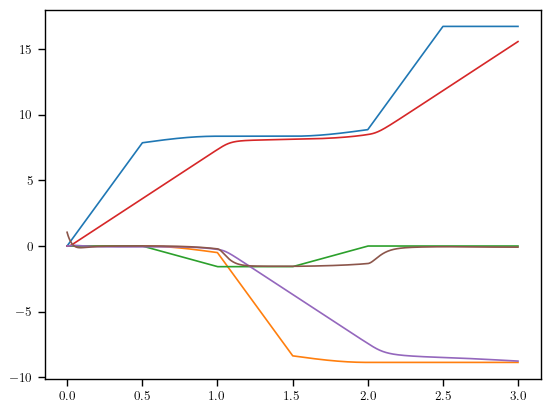

In [42]:
plt.plot(t_span,trajectory)
plt.plot(t_span,controlled_trajectory)

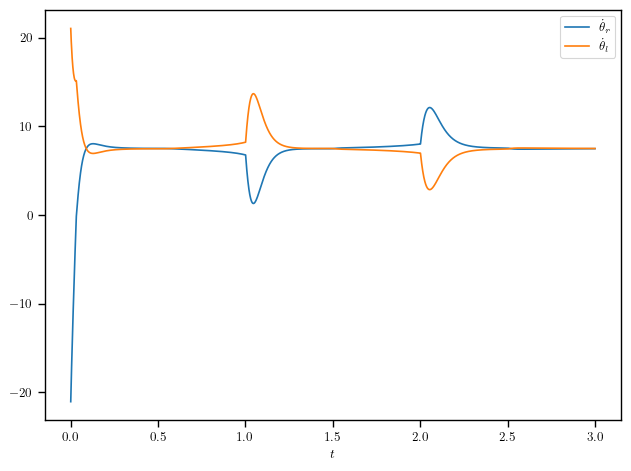

In [43]:
plt.plot(t_span[1:],u_hist, label=[r"$\dot\theta_r$",r"$\dot\theta_l$"])
plt.legend()
plt.xlabel(r'$t$')
plt.tight_layout()